In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(rc={'figure.figsize':(11, 4)})


#read CSV file
df = pd.read_csv('dataOrig.csv', index_col='Date', parse_dates=True)

df_orig = df.copy()

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105175 entries, 2018-02-18 10:45:00 to 2019-02-18 10:45:00
Data columns (total 5 columns):
Demand         105175 non-null float64
OAT            105175 non-null float64
P1VFDOutput    105175 non-null float64
P2VFDOutput    105175 non-null float64
ChWaterPrs     105175 non-null float64
dtypes: float64(5)
memory usage: 4.8 MB


In [3]:
df.describe()

,Demand,OAT,P1VFDOutput,P2VFDOutput,ChWaterPrs
count,105175.000000,105175.000000,105175.000000,105175.000000,105175.000000
mean,45.599886,48.433107,18.257732,22.195243,3.631822
std,31.632237,22.730153,34.992627,38.501321,6.409937
min,0.000000,-25.700000,0.000000,0.000000,0.000000
25%,24.000000,30.200000,0.000000,0.000000,0.000000
50%,30.000000,45.800000,0.000000,0.000000,0.000000
75%,60.000000,68.100000,0.000000,60.300000,0.000000
max,228.000000,104.000000,100.000000,100.000000,37.600000


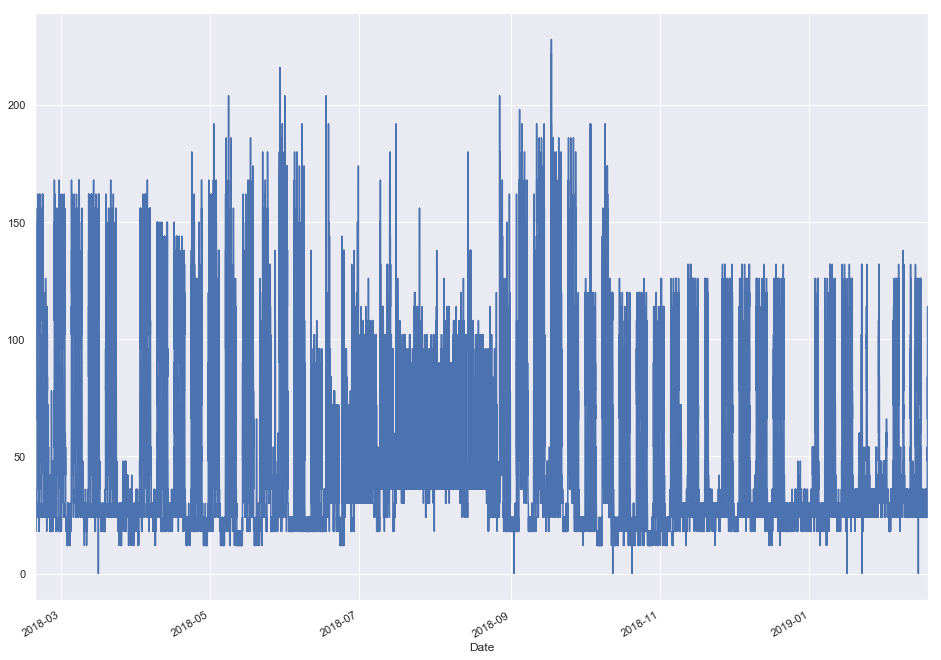

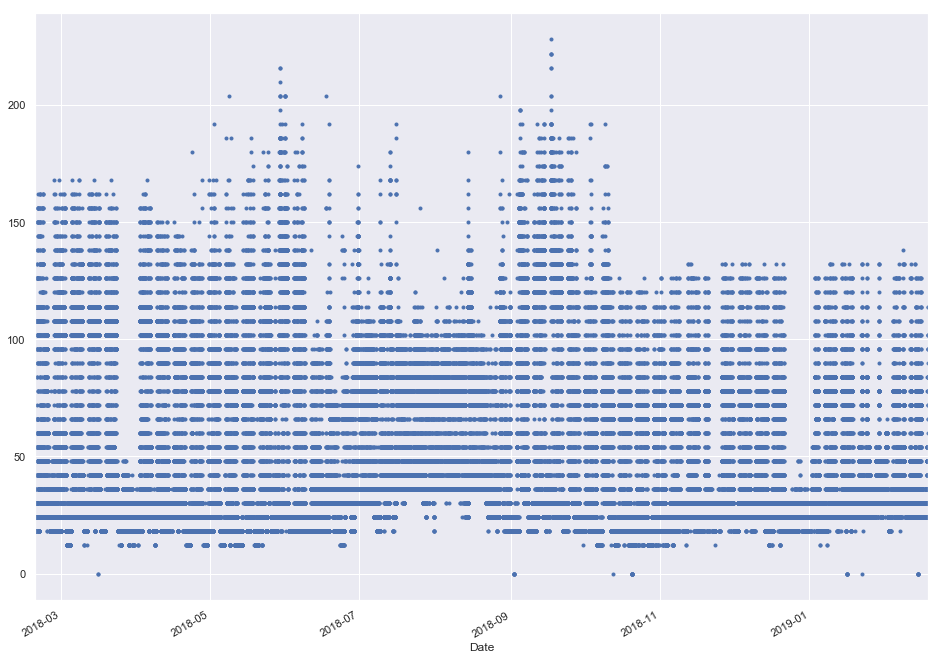

In [4]:
df['Demand'].plot(figsize=(16, 12))
plt.show()

df['Demand'].plot(marker='.', alpha=1, linestyle='None', figsize=(16, 12))

plt.show()

In [5]:
df = df[(df[['Demand']] != 0).all(axis=1)]

df.describe()

,Demand,OAT,P1VFDOutput,P2VFDOutput,ChWaterPrs
count,105143.000000,105143.000000,105143.000000,105143.000000,105143.000000
mean,45.613764,48.435149,18.257832,22.196937,3.632928
std,31.627044,22.731820,34.993222,38.502232,6.410600
min,12.000000,-25.700000,0.000000,0.000000,0.000000
25%,24.000000,30.200000,0.000000,0.000000,0.000000
50%,30.000000,45.800000,0.000000,0.000000,0.000000
75%,60.000000,68.100000,0.000000,60.300000,0.000000
max,228.000000,104.000000,100.000000,100.000000,37.600000


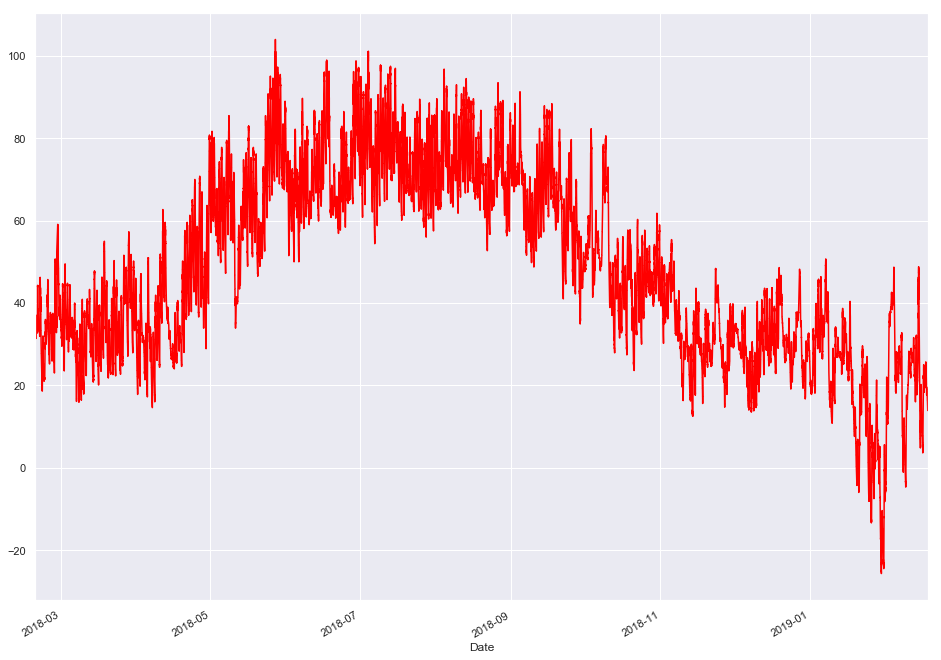

In [6]:
df['OAT'].plot(figsize=(16, 12), color='red')

plt.show()

In [7]:
#create dummy variables
df['month'] = df.index.month
df['hour'] = df.index.strftime('%H').astype('int')
df['minute'] = df.index.strftime('%M').astype('int')
df['day_of_week'] = df.index.dayofweek

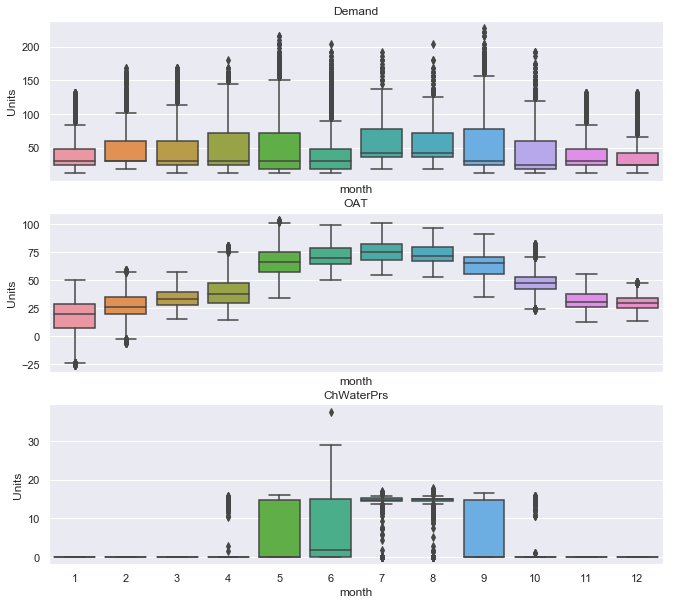

In [8]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['Demand', 'OAT', 'ChWaterPrs', 'P1VFDOutput', 'P2VFDOutput'], axes):
    sns.boxplot(data=df, x='month', y=name, ax=ax)
    ax.set_ylabel('Units')
    ax.set_title(name)
# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')

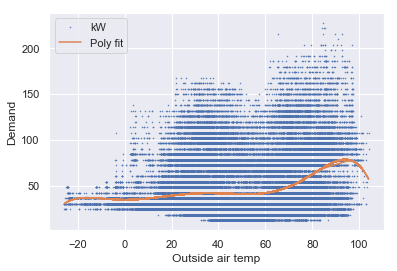

In [38]:
#curve fit attempt

xs = df['OAT']
ys = df['Demand']

p = np.polyfit(xs, ys,deg=6)
ps = np.polyval(p, xs)
plt.plot(xs, ys, ".", label="kW", ms=1)
plt.plot(xs, ps, label="Poly fit")
plt.xlabel("Outside air temp")
plt.ylabel("Demand")
plt.legend();

In [13]:
#https://w2.weather.gov/climate/

import pandas as pd

weatherStation = pd.read_csv('weatherData.csv', index_col='Date', parse_dates=True)
weatherStationMin = weatherStation[['WeatherStation_Min']]
weatherStationMax = weatherStation[['WeatherStation_Max']]

df = pd.read_csv('dataOrig.csv', index_col='Date', parse_dates=True)
weatherDataMin = df.OAT.resample('D').min()
weatherDataMax = df.OAT.resample('D').max()

combinedOaTMin = weatherStationMin.merge(weatherDataMin, left_index=True, right_index=True)

combinedOaTMax = weatherStationMax.merge(weatherDataMax, left_index=True, right_index=True)

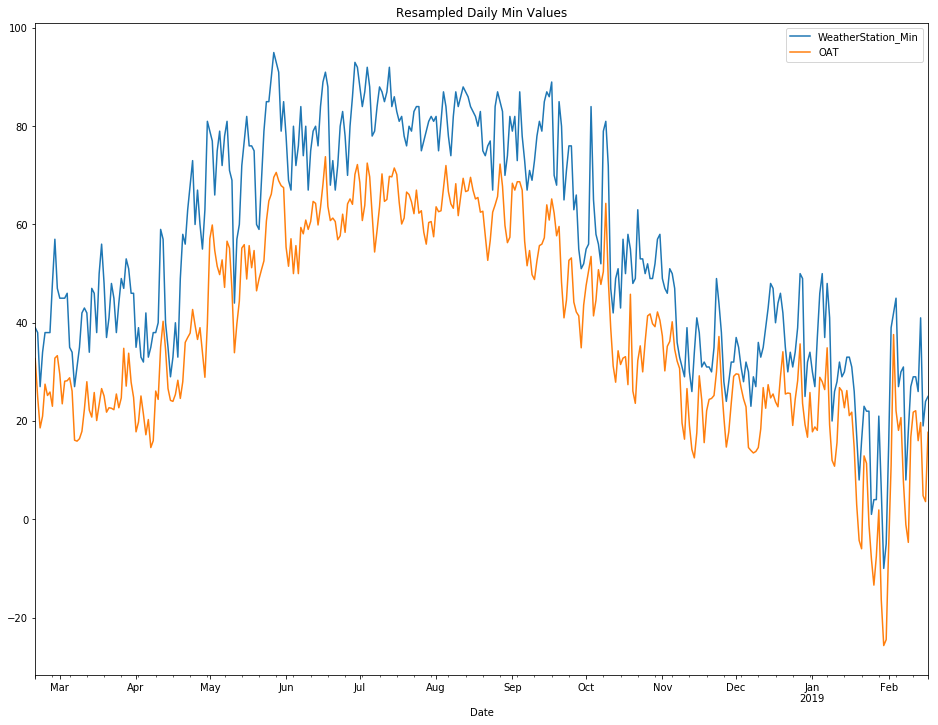

In [16]:
combinedOaTMin.plot(figsize=(16, 12), title='Resampled Daily Min Values')

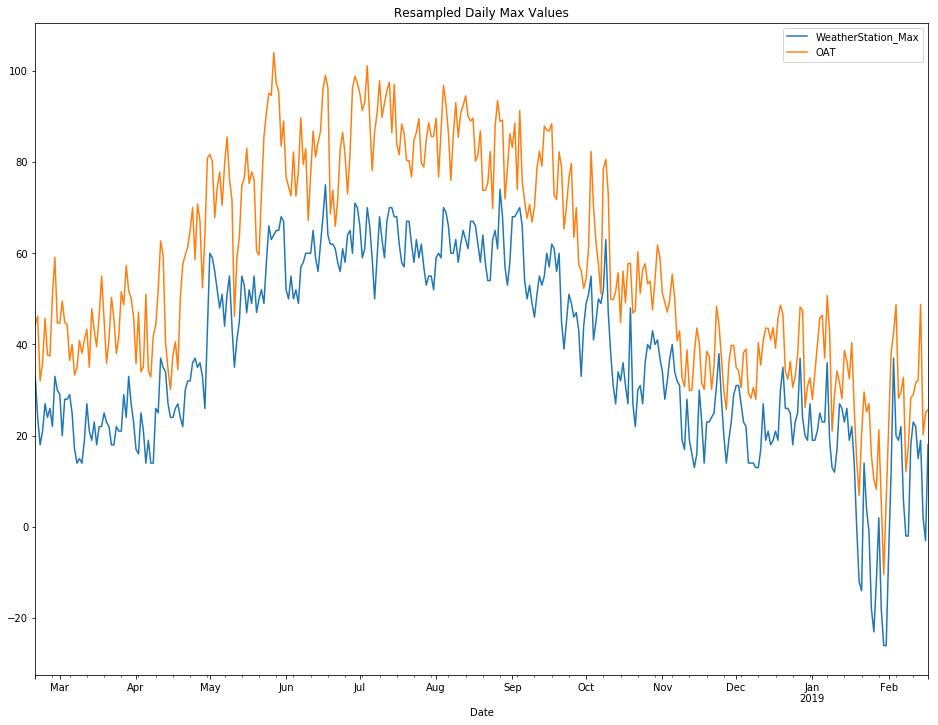

In [17]:
combinedOaTMax.plot(figsize=(16, 12), title='Resampled Daily Max Values')

In [9]:
#df2 = df.drop(['OAT', 'P1VFDOutput', 'P2VFDOutput', 'ChWaterPrs'], axis=1)

df['summer'] = np.where(df['month'].isin([6,7,8,9]), 1, 0)
df['september'] = np.where(df['month'].isin([9]), 1, 0)
df['monday'] = np.where(df['day_of_week'].isin([0]), 1, 0)
df['tuesday'] = np.where(df['day_of_week'].isin([1]), 1, 0)
df['wednesday'] = np.where(df['day_of_week'].isin([2]), 1, 0)
df['thursday'] = np.where(df['day_of_week'].isin([3]), 1, 0)
df['friday'] = np.where(df['day_of_week'].isin([4]), 1, 0)
df['saturday'] = np.where(df['day_of_week'].isin([5]), 1, 0)

df['weekend'] = np.where(df['day_of_week'].isin([5,6]), 1, 0)
df['daytime'] = df['hour'].apply(lambda hr : 1 if (hr > 6 and hr < 18) else 0)

#print(df.describe())

In [10]:
from statsmodels.compat import lzip
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

stats_model = ols('Demand ~ OAT', data=df).fit()
print(stats_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     6164.
Date:                Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                        11:22:46   Log-Likelihood:            -5.0936e+05
No. Observations:              105143   AIC:                         1.019e+06
Df Residuals:                  105141   BIC:                         1.019e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.7550      0.223    133.354      0.0

In [11]:
kW_model2 = ols('Demand ~ OAT + summer + weekend + daytime', data=df).fit()
print(kW_model2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                 1.586e+04
Date:                Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                        11:22:46   Log-Likelihood:            -4.8754e+05
No. Observations:              105143   AIC:                         9.751e+05
Df Residuals:                  105138   BIC:                         9.751e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.0484      0.212    136.791      0.0

In [12]:
#create df's based on hour of day
df['hour_0'] = np.where(df['hour'].isin([0]), 1, 0)
df['hour_1'] = np.where(df['hour'].isin([1]), 1, 0)
df['hour_2'] = np.where(df['hour'].isin([2]), 1, 0)
df['hour_3'] = np.where(df['hour'].isin([3]), 1, 0)
df['hour_4'] = np.where(df['hour'].isin([4]), 1, 0)
df['hour_5'] = np.where(df['hour'].isin([5]), 1, 0)
df['hour_6'] = np.where(df['hour'].isin([6]), 1, 0)
df['hour_7'] = np.where(df['hour'].isin([7]), 1, 0)
df['hour_8'] = np.where(df['hour'].isin([8]), 1, 0)
df['hour_9'] = np.where(df['hour'].isin([9]), 1, 0)
df['hour_10'] = np.where(df['hour'].isin([10]), 1, 0)
df['hour_11'] = np.where(df['hour'].isin([11]), 1, 0)
df['hour_12'] = np.where(df['hour'].isin([12]), 1, 0)
df['hour_13'] = np.where(df['hour'].isin([13]), 1, 0)
df['hour_14'] = np.where(df['hour'].isin([14]), 1, 0)
df['hour_15'] = np.where(df['hour'].isin([15]), 1, 0)
df['hour_16'] = np.where(df['hour'].isin([16]), 1, 0)
df['hour_17'] = np.where(df['hour'].isin([17]), 1, 0)
df['hour_18'] = np.where(df['hour'].isin([18]), 1, 0)
df['hour_19'] = np.where(df['hour'].isin([19]), 1, 0)
df['hour_20'] = np.where(df['hour'].isin([20]), 1, 0)
df['hour_21'] = np.where(df['hour'].isin([21]), 1, 0)
df['hour_22'] = np.where(df['hour'].isin([22]), 1, 0)
df['hour_23'] = np.where(df['hour'].isin([23]), 1, 0)

In [13]:

kW_model3 = ols('Demand ~ OAT + september + monday + tuesday + wednesday + thursday + friday + hour_5 + hour_6 + hour_7 + hour_8 + hour_9 + hour_10 + hour_11 + hour_12 + hour_13 + hour_14 + hour_15 + hour_16 + hour_17 + hour_18 + hour_19 + hour_20 + hour_21 + hour_22', data=df).fit()
print(kW_model3.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     3179.
Date:                Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                        11:22:47   Log-Likelihood:            -4.8275e+05
No. Observations:              105143   AIC:                         9.656e+05
Df Residuals:                  105117   BIC:                         9.658e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2860      0.235      5.478      0.0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000012C3EFC60B8>],
      dtype=object)

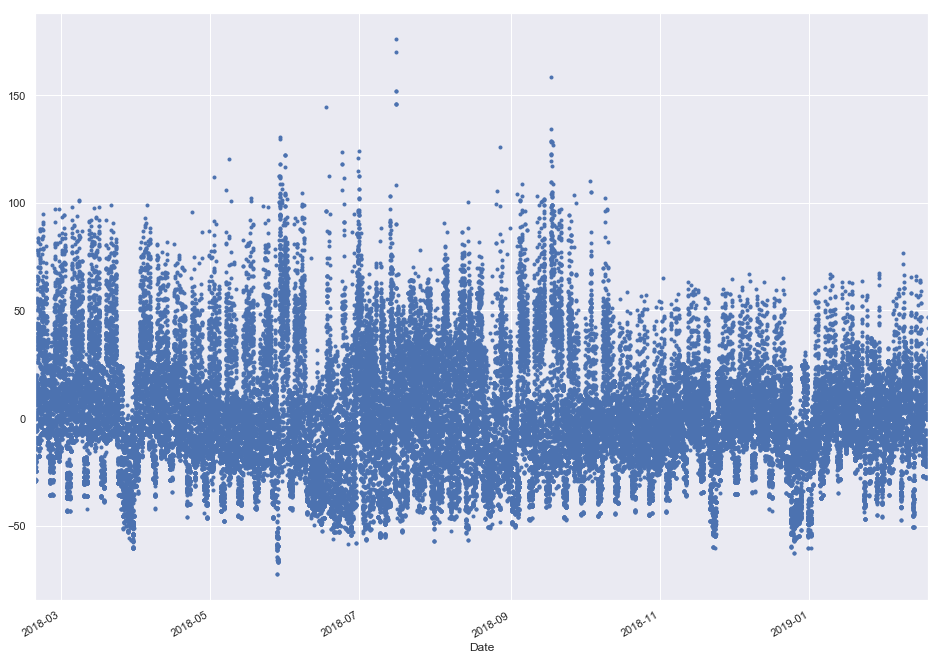

In [14]:
#plot residuals

resiDf = pd.DataFrame()

predictedValues  = kW_model3.fittedvalues
yData = df.Demand

res = yData - predictedValues

res.plot(marker='.', alpha=1, linestyle='None', figsize=(16, 12), subplots=True)

In [15]:
#save df 
df_orig.to_csv('df_orig.csv')

#shuffled data
df_orig = df_orig.sample(frac=1.0)

#find correlation of kW Vs other df's
print(df_orig.corr()['Demand'].sort_values())

NameError: name 'df_orig' is not defined

In [ ]:
#save df 
df_all = df.copy()
df_all.to_csv('df_all.csv')

#shuffled data
df_all = df.sample(frac=1.0)

#find correlation of kW Vs other df's
print(df_all.corr()['Demand'].sort_values())

In [ ]:
#create same dataset as OLS model

df_ols = df[['Demand', 'OAT' , 'september' , 'monday' , 'tuesday' , 'wednesday' , 'thursday' , 'friday' , 'hour_5' , 'hour_6' , 'hour_7' , 'hour_8' , 'hour_9' , 'hour_10' , 'hour_11' , 'hour_12' , 'hour_13' , 'hour_14' , 'hour_15' , 'hour_16' , 'hour_17' , 'hour_18' , 'hour_19' , 'hour_20' , 'hour_21' , 'hour_22']]
df_ols.to_csv('df_ols.csv')

#shuffle data 
df_ols = df_ols.sample(frac=1.0)

#find correlation of kW Vs other df's
print(df_ols.corr()['Demand'].sort_values())

In [ ]:
#create same dataset as OLS model + runtime

df_ols_runtime = df[['Demand', 'OAT' , 'ChWaterPrs' , 'P1VFDOutput' , 'P2VFDOutput' , 'september' , 'monday' , 'tuesday' , 'wednesday' , 'thursday' , 'friday' , 'hour_5' , 'hour_6' , 'hour_7' , 'hour_8' , 'hour_9' , 'hour_10' , 'hour_11' , 'hour_12' , 'hour_13' , 'hour_14' , 'hour_15' , 'hour_16' , 'hour_17' , 'hour_18' , 'hour_19' , 'hour_20' , 'hour_21' , 'hour_22']]
df_ols_runtime.to_csv('df_ols_runtime.csv')

#shuffle data 
df_ols_runtime = df_ols_runtime.sample(frac=1.0)

#find correlation of kW Vs other df's
print(df_ols_runtime.corr()['Demand'].sort_values())

In [ ]:
#Test Decision Tree Regressor 
#from sklearn import preprocessing, cross_validation, neighbors
from sklearn import preprocessing, neighbors
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import mean_squared_error
import math
import numpy as np
 
rmses = []
for i in range(4):
    if i==1:
        aux_df = df_orig
    elif i==2:
        aux_df = df_all
    elif i==3:
        aux_df = df_ols
    else:
        aux_df = df_ols_runtime
 
    X = np.array(aux_df.drop(['Demand'],1))
    y = np.array(aux_df['Demand'])
 
    offset = int(X.shape[0] * 0.7)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test = X[offset:], y[offset:]
 
    #clf = DecisionTreeRegressor(random_state=300, min_samples_leaf=150)
    clf = DecisionTreeRegressor()
 
    clf.fit(X_train, y_train)
    mse = mean_squared_error(y_test, clf.predict(X_test))
    rmse = math.sqrt(mse)
    print("rmse: %.4f" % rmse)
    rmses.append(rmse)
 
print(sum(rmses)/len(rmses))

In [ ]:
#Test random Forest

import numpy as np
from sklearn import preprocessing, neighbors
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
import math
 
rmses = []
for i in range(4):
    if i==1:
        aux_df = df_orig
    elif i==2:
        aux_df = df_all
    elif i==3:
        aux_df = df_ols
    else:
        aux_df = df_ols_runtime
 
    X = np.array(aux_df.drop(['Demand'],1))
    y = np.array(aux_df['Demand'])
 
    offset = int(X.shape[0] * 0.7)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test = X[offset:], y[offset:]
 
    clf = RandomForestRegressor(n_estimators=60, min_samples_split=6)
 
    clf.fit(X_train, y_train)
    mse = mean_squared_error(y_test, clf.predict(X_test))
    rmse = math.sqrt(mse)
    print("rmse: %.4f" % rmse)
    rmses.append(rmse)
 
print(sum(rmses)/len(rmses))

#joblib.dump(clf, 'rfrModel.pkl')

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge
from sklearn import preprocessing, neighbors
from sklearn.linear_model import BayesianRidge 
from sklearn.metrics import mean_squared_error
import math
 
rmses = []
for i in range(4):
    if i==1:
        aux_df = df_orig
    elif i==2:
        aux_df = df_all
    elif i==3:
        aux_df = df_ols
    else:
        aux_df = df_ols_runtime
 
    X = np.array(aux_df.drop(['Demand'],1))
    y = np.array(aux_df['Demand'])
 
    offset = int(X.shape[0] * 0.7)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test = X[offset:], y[offset:]
 
    clf = BayesianRidge()
 
    clf.fit(X_train, y_train)
    mse = mean_squared_error(y_test, clf.predict(X_test))
    rmse = math.sqrt(mse)
    print("rmse: %.4f" % rmse)
    rmses.append(rmse)
 
print(sum(rmses)/len(rmses))

In [ ]:
#test support vector machine regressor

from sklearn import preprocessing, neighbors
from sklearn.svm import SVR 
from sklearn.metrics import mean_squared_error
import math
 
rmses = []
for i in range(4):
    if i==1:
        aux_df = df_orig
    elif i==2:
        aux_df = df_all
    elif i==3:
        aux_df = df_ols
    else:
        aux_df = df_ols_runtime
 
    X = np.array(aux_df.drop(['Demand'],1))
    y = np.array(aux_df['Demand'])
 
    offset = int(X.shape[0] * 0.7)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test = X[offset:], y[offset:]
 
    clf = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    #clf = SVR()
 
    clf.fit(X_train, y_train)
    mse = mean_squared_error(y_test, clf.predict(X_test))
    rmse = math.sqrt(mse)
    print("rmse: %.4f" % rmse)
    rmses.append(rmse)
 
print(sum(rmses)/len(rmses))

In [ ]:
#Test NN, https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor
from sklearn import preprocessing, neighbors
from sklearn.neural_network import MLPRegressor 
from sklearn.metrics import mean_squared_error
import math
 
rmses = []
for i in range(4):
    if i==1:
        aux_df = df_orig
    elif i==2:
        aux_df = df_all
    elif i==3:
        aux_df = df_ols
    else:
        aux_df = df_ols_runtime
 
    X = np.array(aux_df.drop(['Demand'],1))
    y = np.array(aux_df['Demand'])
 
    offset = int(X.shape[0] * 0.7)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test = X[offset:], y[offset:]
 
    clf = MLPRegressor(hidden_layer_sizes = (120, 88, 66, 44, 22, 18, 12, 8), activation = 'relu', solver = 'adam', 
                       learning_rate = 'adaptive', alpha = 1, random_state = 1)
 
    clf.fit(X_train, y_train)
    mse = mean_squared_error(y_test, clf.predict(X_test))
    rmse = math.sqrt(mse)
    print("rmse: %.4f" % rmse)
    rmses.append(rmse)
 
print(sum(rmses)/len(rmses))

#12.6024 with constant learning rate
#    clf = MLPRegressor(hidden_layer_sizes = (100, 75, 50, 25), activation = 'relu', solver = 'sgd', 
                       #learning_rate = 'adaptive', alpha = 1, random_state = 1)
    
#    clf = MLPRegressor(hidden_layer_sizes = (120, 88, 66, 44, 22, 18, 12, 8), activation = 'relu', solver = 'adam',
                      #learning_rate = 'constant', alpha = 1e-5, random_state = 1)

In [ ]:
#Test KNN, https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor
from sklearn import preprocessing, neighbors
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.metrics import mean_squared_error
import math
 
rmses = []
for i in range(4):
    if i==1:
        aux_df = df_orig
    elif i==2:
        aux_df = df_all
    elif i==3:
        aux_df = df_ols
    else:
        aux_df = df_ols_runtime
 
    X = np.array(aux_df.drop(['Demand'],1))
    y = np.array(aux_df['Demand'])
 
    offset = int(X.shape[0] * 0.7)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test = X[offset:], y[offset:]
 
    clf = KNeighborsRegressor(n_neighbors=15,leaf_size=550)
 
    clf.fit(X_train, y_train)
    mse = mean_squared_error(y_test, clf.predict(X_test))
    rmse = math.sqrt(mse)
    print("rmse: %.4f" % rmse)
    rmses.append(rmse)
 
print(sum(rmses)/len(rmses))